# Overview

This notebook is used to experiment with various modeling techniques.

# Setup

In [1]:
# Import libraries
import json
import pandas as pd
import numpy as np
import seaborn as sb
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
# Read data, specifically parsing date columns as dates
data = pd.read_csv('../../data/processed/cleaned_data.csv', parse_dates=['RegistrationTime'])

In [3]:
data.head()

,Random_ID,RegistrationTime,OutCome,DonationType,DonationLocation
0,52156190,2015-06-27 12:47:00,Donation,Whole Blood,Center
1,52825057,2015-02-26 09:53:00,Donation,2 Units RBC,Mobile
2,53025596,2015-09-08 16:49:59,Donation,Whole Blood,Mobile
3,2056692,2015-08-26 12:15:00,Donation,Whole Blood,Mobile
4,52879521,2015-01-26 17:18:00,Incomplete,Whole Blood,Center


# Form time series dataset (count of new donors per 30-day period)

In [4]:
target_windows = pd.concat([
    pd.Series(pd.date_range(start='2015-01-01 00:00:00', end='2019-09-30 00:00:00', freq='MS')),
    pd.Series(pd.date_range(start='2015-01-01 23:59:59', end='2019-09-30 23:59:59', freq='M'))
], axis=1)
target_windows.columns = ['StartDatetime', 'EndDatetime']
target_windows['NewDonors'] = 0
target_windows.head()

,StartDatetime,EndDatetime,NewDonors
0,2015-01-01,2015-01-31 23:59:59,0
1,2015-02-01,2015-02-28 23:59:59,0
2,2015-03-01,2015-03-31 23:59:59,0
3,2015-04-01,2015-04-30 23:59:59,0
4,2015-05-01,2015-05-31 23:59:59,0


In [5]:
# Generate 30-day date ranges
# target_windows = pd.DataFrame(pd.date_range(start='2015-01-01 00:00:00', end='2019-09-30 00:00:00', freq='30D'), columns=['StartTime'])
# target_windows['EndDatetime'] = target_windows['StartDatetime'] + timedelta(days=30, hours=23, minutes=59, seconds=59)
# target_windows['NewDonors'] = 0
# target_windows.head()

In [6]:
# Group by Random_ID to get each person's first registration time
new_donors = data.groupby('Random_ID', as_index=False).agg({'RegistrationTime': 'min'})
new_donors

,Random_ID,RegistrationTime
0,54260,2016-02-28 18:00:00
1,54261,2015-05-28 13:23:00
2,54273,2015-10-18 16:13:00
3,54312,2016-05-30 14:09:00
4,54330,2015-06-04 15:00:00
...,...,...
1527706,55777872,2019-08-20 11:04:00
1527707,55777873,2019-08-20 12:11:00
1527708,55777874,2019-08-20 11:24:00
1527709,55777875,2019-08-20 11:34:59


In [26]:
def calculate_donor_count(row, raw_data):
    # Calculates number of new donors using raw data DataFrame
    window_subset = raw_data[(raw_data['RegistrationTime'] >= row['StartDatetime']) & (raw_data['RegistrationTime'] <= row['EndDatetime'])]
    return len(window_subset.index)

# Populate NewDonors
target_windows['NewDonors'] = target_windows.apply(lambda row: calculate_donor_count(row, new_donors), axis=1)
target_windows.head()

,StartDatetime,EndDatetime,NewDonors
0,2015-01-01,2015-01-31 23:59:59,17330
1,2015-02-01,2015-02-28 23:59:59,17301
2,2015-03-01,2015-03-31 23:59:59,20308
3,2015-04-01,2015-04-30 23:59:59,18877
4,2015-05-01,2015-05-31 23:59:59,17179


In [8]:
# Convert to a time series-friendly DataFrame with just date as an index and a single variable
series = target_windows.copy().drop(['EndDatetime'], axis=1).set_index('StartDatetime').squeeze()
series = series[(series != 0) & (series.index.year != 2015)]
series.head()

StartDatetime
2016-01-01    47475
2016-02-01    42764
2016-03-01    38823
2016-04-01    34492
2016-05-01    33310
Name: NewDonors, dtype: int64

In [9]:
series[series.index.month == 8]

StartDatetime
2016-08-01    35513
2017-08-01    27121
2018-08-01    24878
2019-08-01    14615
Name: NewDonors, dtype: int64

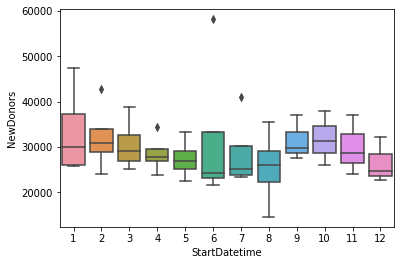

In [10]:
sb.boxplot(series.index.month, series)

# Explore returning donor counts

In [13]:
returning_donors = data.merge(new_donors, how='left', on='Random_ID')
returning_donors.head()

,Random_ID,RegistrationTime_x,OutCome,DonationType,DonationLocation,RegistrationTime_y
0,52156190,2015-06-27 12:47:00,Donation,Whole Blood,Center,2015-06-27 12:47:00
1,52825057,2015-02-26 09:53:00,Donation,2 Units RBC,Mobile,2015-02-26 09:53:00
2,53025596,2015-09-08 16:49:59,Donation,Whole Blood,Mobile,2015-09-08 16:49:59
3,2056692,2015-08-26 12:15:00,Donation,Whole Blood,Mobile,2015-08-26 12:15:00
4,52879521,2015-01-26 17:18:00,Incomplete,Whole Blood,Center,2015-01-26 17:18:00


In [14]:
returning_donors = returning_donors[returning_donors['RegistrationTime_x'] != returning_donors['RegistrationTime_y']]
returning_donors.rename(columns={'RegistrationTime_x': 'RegistrationTime', 'RegistrationTime_y': 'FirstRegistrationTime'}, inplace=True)
returning_donors.head()

,Random_ID,RegistrationTime,OutCome,DonationType,DonationLocation,FirstRegistrationTime
6,50358955,2015-03-19 07:56:00,Donation,RBC with Platelets,Mobile,2015-01-22 07:45:00
18,194215,2015-09-07 15:04:00,Donation,Whole Blood,Center,2015-02-06 13:00:00
27,52975709,2015-09-09 14:49:00,Donation,Whole Blood,Mobile,2015-07-08 15:17:00
29,50971396,2015-05-13 15:30:00,Donation,Whole Blood,Mobile,2015-03-18 13:13:00
34,641920,2015-07-17 16:30:00,Donation,Whole Blood,Mobile,2015-05-15 16:02:00


In [27]:
target_windows['ReturningDonors'] = target_windows.apply(lambda row: calculate_donor_count(row, returning_donors), axis=1)
target_windows.head()

,StartDatetime,EndDatetime,NewDonors,ReturningDonors
0,2015-01-01,2015-01-31 23:59:59,17330,155
1,2015-02-01,2015-02-28 23:59:59,17301,500
2,2015-03-01,2015-03-31 23:59:59,20308,1692
3,2015-04-01,2015-04-30 23:59:59,18877,2322
4,2015-05-01,2015-05-31 23:59:59,17179,3067


In [28]:
# Convert to a time series-friendly DataFrame with just date as an index and a single variable
series = target_windows.copy().drop(['EndDatetime', 'NewDonors'], axis=1).set_index('StartDatetime').squeeze()
series = series[(series != 0) & (series.index.year != 2015)]
series.head()

StartDatetime
2016-01-01    25086
2016-02-01    24748
2016-03-01    32014
2016-04-01    32170
2016-05-01    35683
Name: ReturningDonors, dtype: int64

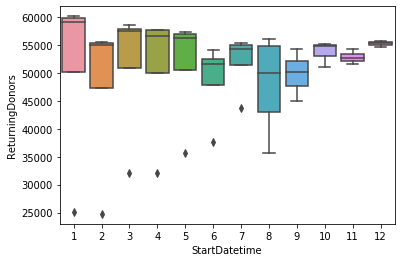

In [29]:
sb.boxplot(series.index.month, series)

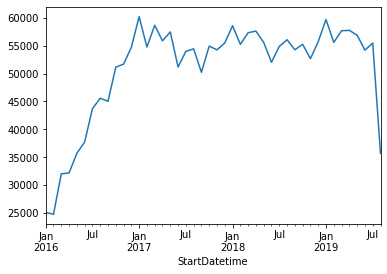

In [31]:
series.plot()